# Importing the necessary Libraries

In [54]:
# vector_script.py
from dotenv import load_dotenv
import os
from langchain.chains import LLMChain
from langchain_chroma import Chroma
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from vector_store import create_db, store_report
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from prompt import prompt_with_data, prompt_without_data
from nemoguardrails import LLMRails, RailsConfig
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import List, Callable, Any
from langchain_core.pydantic_v1 import BaseModel, Field
from prompt import prompt_with_route_query,prompt_with_TavilySearchInput,prompt_with_query_correction
from prompt import prompt_with_memory_history
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from keys import nvidia_api_key,tavily_api_key,langchain_api_key,model_memory
import json
import asyncio



# Configure the environment 

In [55]:
os.environ["NVIDIA_API_KEY"] = "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"
embedder = NVIDIAEmbeddings()

In [56]:
import sqlite3

def retrieve_data(Email_Id: str) -> str:
    """
    Retrieves the last progress report of a student from the SQLite database using Email_Id.

    This function connects to the 'student_report.db' SQLite database and queries the 
    'new_Student_Progress_report' table for the report associated with the provided Email_Id. 
    If a report is found, the last one is returned as a string; otherwise, the function returns None.

    Args:
        Email_Id (str): The unique email identifier for the student whose report is to be retrieved.

    Returns:
        str or None: The student's last progress report as a string if found, otherwise None.
    """
    path = "/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/backend/base/student_report.db"
    my_connection = sqlite3.connect(path)
    my_cursor = my_connection.cursor()
    
    # Retrieve reports based on Email_Id
    my_cursor.execute('SELECT Timestamp,Report FROM new_Student_Progress_report WHERE Email_Id = ?', (Email_Id,))
    results = my_cursor.fetchall()
    
    my_connection.close()
    
    # Check if any results were found
    if results:
        # Return the last report as a string
        return results  # Access the last element and the first item in the tuple
    else:
        return None


In [58]:
report=retrieve_data("pankaj@gmail.com")
report

[('2024-10-15 09:03:05',
  "After analyzing the provided JSON data, I have generated the report based on the student's performance in the NEET Biology exam.\n\n**Overall Score Summary**\n\n* Total Questions Answered: 30\n* Total Correct Answers: 6\n* Total Incorrect Answers: 24\n* Overall Accuracy Percentage: 20%\n\n**Chapter-wise Analysis**\n\n* **Reproduction**:\n  * Total Questions Answered: 12\n  * Correct Answers: 2\n  * Incorrect Answers: 10\n  * Accuracy Percentage: 16.67%\n* **Diversity in Living World**:\n  * Total Questions Answered: 3\n  * Correct Answers: 1\n  * Incorrect Answers: 2\n  * Accuracy Percentage: 33.33%\n* **Cell Structure and Function**:\n  * Total Questions Answered: 4\n  * Correct Answers: 1\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 25%\n* **Genetics and Evolution**:\n  * Total Questions Answered: 3\n  * Correct Answers: 0\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 0%\n* **Structural Organization in Plants and Animals**:\n  * Total Question

In [16]:
with open("/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/backend/base/report.txt","r") as f:
    report=f.read()

In [20]:
report 

"After analyzing the provided data, I've generated a detailed report of the student's exam performance.\n\n**Overall Score Summary**\n\n* Total Questions Answered: 30\n* Total Correct Answers: 10\n* Total Incorrect Answers: 20\n* Overall Accuracy Percentage: 33.33%\n\n**Chapter-wise Analysis**\n\n* **Reproduction**:\n  * Total Questions Answered: 4\n  * Correct Answers: 1\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 25%\n* **Genetics and Evolution**:\n  * Total Questions Answered: 5\n  * Correct Answers: 2\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 40%\n* **Diversity in Living World**:\n  * Total Questions Answered: 4\n  * Correct Answers: 1\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 25%\n* **Plant Physiology**:\n  * Total Questions Answered: 2\n  * Correct Answers: 1\n  * Incorrect Answers: 1\n  * Accuracy Percentage: 50%\n* **Human Physiology**:\n  * Total Questions Answered: 2\n  * Correct Answers: 0\n  * Incorrect Answers: 2\n  * Accuracy Percentage: 0%\n* 

In [17]:
print(report)

After analyzing the provided data, I've generated a detailed report of the student's exam performance.

**Overall Score Summary**

* Total Questions Answered: 30
* Total Correct Answers: 10
* Total Incorrect Answers: 20
* Overall Accuracy Percentage: 33.33%

**Chapter-wise Analysis**

* **Reproduction**:
  * Total Questions Answered: 4
  * Correct Answers: 1
  * Incorrect Answers: 3
  * Accuracy Percentage: 25%
* **Genetics and Evolution**:
  * Total Questions Answered: 5
  * Correct Answers: 2
  * Incorrect Answers: 3
  * Accuracy Percentage: 40%
* **Diversity in Living World**:
  * Total Questions Answered: 4
  * Correct Answers: 1
  * Incorrect Answers: 3
  * Accuracy Percentage: 25%
* **Plant Physiology**:
  * Total Questions Answered: 2
  * Correct Answers: 1
  * Incorrect Answers: 1
  * Accuracy Percentage: 50%
* **Human Physiology**:
  * Total Questions Answered: 2
  * Correct Answers: 0
  * Incorrect Answers: 2
  * Accuracy Percentage: 0%
* **Biomolecules**:
  * Total Questions

In [18]:
# def progress_compare(report):
#     # Regex pattern to match the data for progress comparison
#     pattern = r"\*\*Overall Accuracy\*\*:\n\s+\*\s+Previous:\s+([\d.]+)%\n\s+\*\s+Current:\s+([\d.]+)%\n\s+\*\s+Change:\s+(\w+)"
#     match = re.search(pattern, report)
    
#     if match:
#         # Extract the matched groups
#         previous_accuracy = match.group(1)
#         current_accuracy = match.group(2)
#         change = match.group(3)
        
#         # Create a DataFrame
#         data = {
#             'Previous Accuracy': [previous_accuracy],
#             'Current Accuracy': [current_accuracy],
#             'Change': [change]
#         }
#         df = pd.DataFrame(data)
#         return df
#     else:
#         print("No match found.")
#         return pd.DataFrame()  # Return an empty DataFrame if no match is found

In [33]:
# import re
# import pandas as pd

# def progress_compare(report):
#     # Updated regex pattern to match the progress comparison section
#     pattern = r"\*\*Overall Accuracy\*\*:\n\s+\*\s+Previous:\s+([\d.]+)%\n\s+\*\s+Current:\s+([\d.]+)%\n\s+\*\s+Change:\s+([-+]?\d+\.?\d*)%\s+\((\w+)\)"
    
#     match = re.search(pattern, report)
    
#     if match:
#         # Extract the matched groups
#         previous_accuracy = match.group(1)
#         current_accuracy = match.group(2)
#         change_percentage = match.group(3)
#         change_description = match.group(4)
        
#         # Create a DataFrame
#         data = {
#             'Previous Accuracy': [previous_accuracy],
#             'Current Accuracy': [current_accuracy],
#             'Change (%)': [change_percentage],
#             'Description': [change_description]
#         }
#         df = pd.DataFrame(data)
#         return df
#     else:
#         print("No match found.")
#         return pd.DataFrame()  # Return an empty DataFrame if no match is found


# df = progress_compare(report)
# print(df)


In [34]:
# # Convert the accuracy values to float for plotting
# df['Previous Accuracy'] = df['Previous Accuracy'].astype(float)
# df['Current Accuracy'] = df['Current Accuracy'].astype(float)

# # Reshape the DataFrame for plotting
# df_long = df.melt(value_vars=["Previous Accuracy", "Current Accuracy"],
#                   var_name="Accuracy Type", value_name="Percentage")

# # Define the path for saving the plot
# path = "/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/frontend/myapp/src/graphs"

# # Create a grouped bar plot with text values displayed
# fig = px.bar(df_long, x="Accuracy Type", y="Percentage", color="Accuracy Type", 
#              title="Accuracy Comparison with Respect to Last Exam",
#              labels={"Percentage": "Accuracy (%)"},
#              text='Percentage',  # Display values on the bars
#              height=600)

# # Update layout for better visualization
# fig.update_layout(
#     yaxis_title="Accuracy (%)",
#     xaxis_title="Accuracy Type",
#     yaxis=dict(range=[0, 100])
# )

# # # Display the plot
# # progress_compare_plot_path = os.path.join(path, "progress_compare.png")
# # fig.write_image(progress_compare_plot_path)
# fig.show()

In [35]:
with open("/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/backend/base/report.txt","r") as f:
    report=f.read()

In [40]:
report

"After analyzing the provided data, I've generated a detailed report of the student's exam performance.\n\n**Overall Score Summary**\n\n* Total Questions Answered: 30\n* Total Correct Answers: 10\n* Total Incorrect Answers: 20\n* Overall Accuracy Percentage: 33.33%\n\n**Chapter-wise Analysis**\n\n* **Reproduction**:\n  * Total Questions Answered: 4\n  * Correct Answers: 1\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 25%\n* **Genetics and Evolution**:\n  * Total Questions Answered: 5\n  * Correct Answers: 2\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 40%\n* **Diversity in Living World**:\n  * Total Questions Answered: 4\n  * Correct Answers: 1\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 25%\n* **Plant Physiology**:\n  * Total Questions Answered: 2\n  * Correct Answers: 1\n  * Incorrect Answers: 1\n  * Accuracy Percentage: 50%\n* **Human Physiology**:\n  * Total Questions Answered: 2\n  * Correct Answers: 0\n  * Incorrect Answers: 2\n  * Accuracy Percentage: 0%\n* 

In [44]:
import re
import pandas as pd

def extract_topic_data(text):
    # Regex pattern to capture chapter and subtopic details
    topic_pattern = re.compile(
        r"\*\*\s*([^*]+)\s*\*\*:\n\s*(.*?)\s*(?=\*\*|\Z)", re.DOTALL
    )
    
    topics = []

    for match in topic_pattern.finditer(text):
        chapter_name = match.group(1).strip()
        subtopics_data = match.group(2).strip()
        
        # Extract subtopics using another regex
        subtopic_pattern = re.compile(
            r"\*\s*Subtopic:\s*([^\n]+)\n\s*"
            r"- Questions Attempted:\s*(\d+)\n\s*"
            r"\*\s*Correct Answers:\s*(\d+)\n\s*"
            r"\*\s*Incorrect Answers:\s*(\d+)\n\s*"
            r"\*\s*Accuracy Percentage:\s*([\d.]+)%"
        )
        
        for submatch in subtopic_pattern.finditer(subtopics_data):
            subtopic_name = submatch.group(1).strip()
            questions_attempted = int(submatch.group(2))
            correct_answers = int(submatch.group(3))
            incorrect_answers = int(submatch.group(4))
            accuracy_percentage = float(submatch.group(5))
            
            topics.append({
                "Chapter": chapter_name,
                "Subtopic": subtopic_name,
                "Questions Attempted": questions_attempted,
                "Correct Answers": correct_answers,
                "Incorrect Answers": incorrect_answers,
                "Accuracy Percentage": accuracy_percentage
            })

    return pd.DataFrame(topics)




,Chapter,Subtopic,Questions Attempted,Correct Answers,Incorrect Answers,Accuracy Percentage
0,Reproduction,Male Reproductive System,2,1,1,50.0
1,Reproduction,Female Reproductive System,1,0,1,0.0
2,Reproduction,Embryonic Development,1,0,1,0.0
3,Genetics and Evolution,Mendelian Genetics,2,1,1,50.0
4,Genetics and Evolution,Evolution,2,1,1,50.0
5,Genetics and Evolution,Phylogeny,1,0,1,0.0
6,Diversity in Living World,Biodiversity,2,1,1,50.0
7,Diversity in Living World,Classification,1,0,1,0.0
8,Diversity in Living World,Ecosystems,1,0,1,0.0
9,Plant Physiology,Photosynthesis,1,0,1,0.0


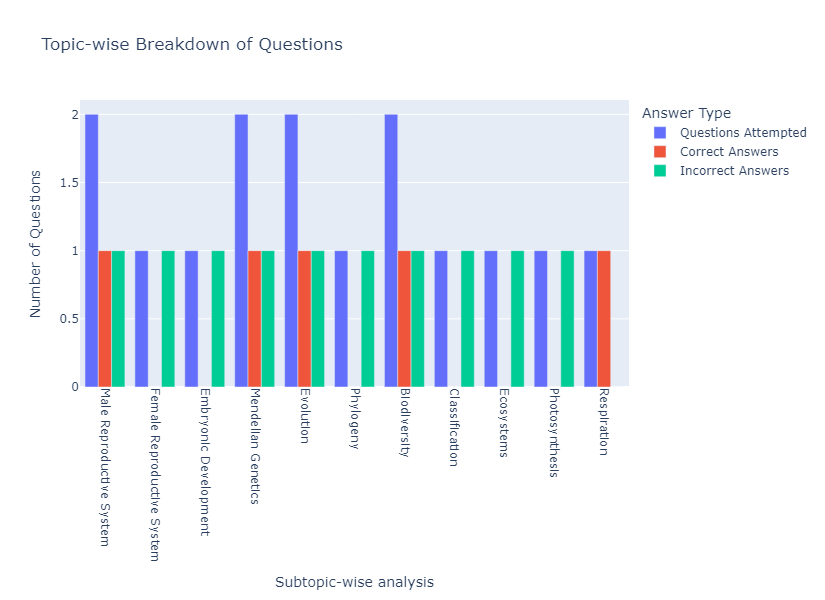

In [48]:
# Reshape the DataFrame for plotting
df_long = topic_df.melt(id_vars=["Chapter", "Subtopic"], 
                  value_vars=["Questions Attempted", "Correct Answers", "Incorrect Answers"],
                  var_name="Answer Type", value_name="Count")

# Create a grouped bar plot
fig = px.bar(df_long, x="Subtopic", y="Count", color="Answer Type", 
             barmode="group", 
             title="Topic-wise Breakdown of Questions",
             labels={"Count": "Number of Questions"},
             height=600)

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Subtopic-wise analysis",
    yaxis_title="Number of Questions",
    xaxis_tickangle=90,
    )

# # Display the plot
# topic_wise_plot_path = os.path.join(path, "topic_wise_breakdown.png")
# fig.write_image(topic_wise_plot_path)
fig.show()

In [28]:
extract_topic_data(report)

""


In [19]:
progress_compare(report)

No match found.


""


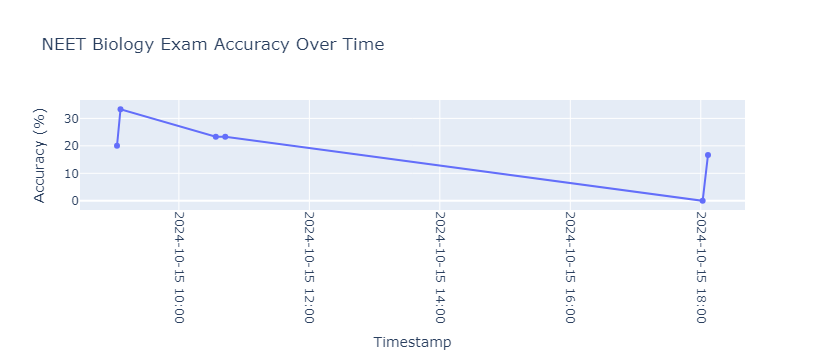

In [147]:
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create a line plot using Plotly
fig = px.line(df, x='Timestamp', y='Overall Accuracy Percentage', 
              title='NEET Biology Exam Accuracy Over Time',
              labels={'Overall Accuracy Percentage': 'Accuracy (%)'},
              markers=True)

# Update the x-axis to show both date and time consistently and rotate labels
fig.update_xaxes(tickformat="%Y-%m-%d %H:%M", tickangle=90)  # Set the format to show date and time and rotate labels


# Show the plot
fig.show()

In [83]:
store_report("gmail@.com","i am vishnu singh")
store_report("gmail@.com","iam pankaj singh")

In [80]:
# import sqlite3
# def retrieve_data(Email_Id: str) -> str:
#     """
#     Retrieves the progress report of a student from the SQLite database using Email_Id.

#     This function connects to the 'student_report.db' SQLite database and queries the 
#     'new_Student_Progress_report' table for the report associated with the provided Email_Id. 
#     If a report is found, it is returned as a string; otherwise, the function returns None.

#     Args:
#         Email_Id (str): The unique email identifier for the student whose report is to be retrieved.

#     Returns:
#         str or None: The student's progress report as a string if found, otherwise None.
#     """
#     path="/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/backend/base/student_report.db"
#     my_connection = sqlite3.connect(path)
#     my_cursor = my_connection.cursor()
    
#     # Retrieve report based on Email_Id
#     my_cursor.execute('SELECT Report FROM new_Student_Progress_report WHERE Email_Id = ?', (Email_Id,))
#     result = my_cursor.fetchall()
#     print(result)
#     my_connection.close()
    
#     if result:
#         return result
#     else:
#         return None


In [55]:
with open("/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/backend/base/report.txt","r") as f:
    report=f.read()

In [81]:
retrieve_data("pankaj@gmail.com")

"After analyzing the provided JSON data, I have generated the report based on the student's performance in the NEET Biology exam.\n\n**Overall Score Summary**\n\n* Total Questions Answered: 30\n* Total Correct Answers: 6\n* Total Incorrect Answers: 24\n* Overall Accuracy Percentage: 20%\n\n**Chapter-wise Analysis**\n\n* **Reproduction**:\n  * Total Questions Answered: 12\n  * Correct Answers: 2\n  * Incorrect Answers: 10\n  * Accuracy Percentage: 16.67%\n* **Diversity in Living World**:\n  * Total Questions Answered: 3\n  * Correct Answers: 1\n  * Incorrect Answers: 2\n  * Accuracy Percentage: 33.33%\n* **Cell Structure and Function**:\n  * Total Questions Answered: 4\n  * Correct Answers: 1\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 25%\n* **Genetics and Evolution**:\n  * Total Questions Answered: 3\n  * Correct Answers: 0\n  * Incorrect Answers: 3\n  * Accuracy Percentage: 0%\n* **Structural Organization in Plants and Animals**:\n  * Total Questions Answered: 2\n  * Correct 

In [32]:
print(report)

After analyzing the provided data, I've generated a detailed report of the student's exam performance.

**Overall Score Summary**

* Total Questions Answered: 30
* Total Correct Answers: 10
* Total Incorrect Answers: 20
* Overall Accuracy Percentage: 33.33%

**Chapter-wise Analysis**

* **Reproduction**:
  * Total Questions Answered: 4
  * Correct Answers: 1
  * Incorrect Answers: 3
  * Accuracy Percentage: 25%
* **Genetics and Evolution**:
  * Total Questions Answered: 5
  * Correct Answers: 2
  * Incorrect Answers: 3
  * Accuracy Percentage: 40%
* **Diversity in Living World**:
  * Total Questions Answered: 4
  * Correct Answers: 1
  * Incorrect Answers: 3
  * Accuracy Percentage: 25%
* **Plant Physiology**:
  * Total Questions Answered: 2
  * Correct Answers: 1
  * Incorrect Answers: 1
  * Accuracy Percentage: 50%
* **Human Physiology**:
  * Total Questions Answered: 2
  * Correct Answers: 0
  * Incorrect Answers: 2
  * Accuracy Percentage: 0%
* **Biomolecules**:
  * Total Questions

# Initialize the LlamaParse

In [186]:
llm = ChatNVIDIA(model="nvidia/usdcode-llama3-70b-instruct")

In [189]:
# Load environment variables
nvidia_api_key = "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"
tavily_api_key = "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"
langchain_api_key = "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"

os.environ["NVIDIA_API_KEY"] = nvidia_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key

In [149]:
with open("/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/backend/base/report.txt","r") as f:
    report=f.read()

In [150]:
import re
import pandas as pd

def progress_compare(report):
    # Regex pattern to match the data for progress comparison
    pattern = r"\*\*Overall Accuracy\*\*:\n\s+\*\s+Previous:\s+([\d.]+)%\n\s+\*\s+Current:\s+([\d.]+)%\n\s+\*\s+Change:\s+(\w+)"
    match = re.search(pattern, report)
    
    if match:
        # Extract the matched groups
        previous_accuracy = match.group(1)
        current_accuracy = match.group(2)
        change = match.group(3)
        
        # Create a DataFrame
        data = {
            'Previous Accuracy (%)': [previous_accuracy],
            'Current Accuracy (%)': [current_accuracy],
            'Change': [change]
        }
        df = pd.DataFrame(data)
        return df
    else:
        print("No match found.")
        return pd.DataFrame()  # Return an empty DataFrame if no match is found


df = progress_compare(report)
print(df)


  Previous Accuracy (%) Current Accuracy (%)   Change
0                    20                16.67  Decline


In [ ]:
#Convert the accuracy values to float for plotting
df['Previous Accuracy (%)'] = df['Previous Accuracy (%)'].astype(float)
df['Current Accuracy (%)'] = df['Current Accuracy (%)'].astype(float)

# Plotting
plt.figure(figsize=(8, 5))

# Bar plot for accuracies
bar_labels = df.columns[:-1]  # Exclude 'Change' column for bar labels
bar_values = df.iloc[0, :-1].values  # Exclude 'Change' column values

plt.bar(bar_labels, bar_values, color=['blue', 'orange'], alpha=0.7, label='Accuracy')

# Line plot for trend
plt.plot(bar_labels, bar_values, color='red', marker='o', linestyle='-', linewidth=2, label='Accuracy Trend')

# Adding labels and title
plt.ylabel('Percentage (%)')
plt.title('Accuracy Comparison with Trend Line')
plt.ylim(0, 100)  # Set y-axis limit for better visualization
plt.axhline(0, color='black', linewidth=0.8)  # Optional: Add horizontal line at y=0
plt.legend()

# Display the values on top of the bars
for index, value in enumerate(bar_values):
    plt.text(index, value + 1, f'{value}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import re

# Define the function to extract chapter data
def extract_chapter_data(text):
    chapter_pattern = re.compile(
        r"\*\*\s*([^*]+)\s*\*\*:\s*"
        r"\* Total Questions Answered:\s*(\d+)\s*"
        r"\* Correct Answers:\s*(\d+)\s*"
        r"\* Incorrect Answers:\s*(\d+)\s*"
        r"\* Accuracy Percentage:\s*([\d.]+)%", re.MULTILINE
    )
    
    chapters = []
    
    for match in chapter_pattern.finditer(text):
        chapter_name = match.group(1).strip()
        total_questions = int(match.group(2))
        correct_answers = int(match.group(3))
        incorrect_answers = int(match.group(4))
        accuracy_percentage = float(match.group(5))
        
        chapters.append({
            "Chapter": chapter_name,
            "Total Questions": total_questions,
            "Correct Answers": correct_answers,
            "Incorrect Answers": incorrect_answers,
            "Accuracy Percentage": accuracy_percentage
        })
    
    return chapters


# Extract chapter data
chapter_data = extract_chapter_data(report)

df = pd.DataFrame(chapter_data)




In [31]:
import re
import pandas as pd
import plotly.express as px

path = "/hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/frontend/myapp/src/graphs"

# Extract chapter data from the report
chapter_data = extract_chapter_data(report)

# Convert the chapter data into a DataFrame
df_chapter_wise = pd.DataFrame(chapter_data)

# Reshape the DataFrame for Plotly
df_long = df_chapter_wise.melt(
    id_vars='Chapter', 
    value_vars=['Total Questions', 'Correct Answers', 'Incorrect Answers'], 
    var_name='Answer Type', 
    value_name='Count'
)

# Create a bar plot using Plotly
fig = px.bar(
    df_long, 
    x='Chapter', 
    y='Count', 
    color='Answer Type', 
    barmode='group',  # Side-by-side bars for each "Answer Type"
    title='Chapter-wise Question Analysis',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Customize the plot (add labels, rotate x-axis for readability)
fig.update_layout(
    xaxis_title='Chapter', 
    yaxis_title='Number of Questions',
    title_font_size=16,
    xaxis_tickangle=-90  # Rotate x-axis labels
)

# Define the file path for saving the bar plot
chapter_wise_plot_path = os.path.join(path, "chapter_wise_analysis.png")

# Save the bar plot as an image
fig.write_image(chapter_wise_plot_path)

print(f"Bar plot saved successfully at: {chapter_wise_plot_path}")


Bar plot saved successfully at: /hackathon_teams/hack_team_11/workspace/Nvidia_nim_hackathon/frontend/myapp/src/graphs/chapter_wise_analysis.png


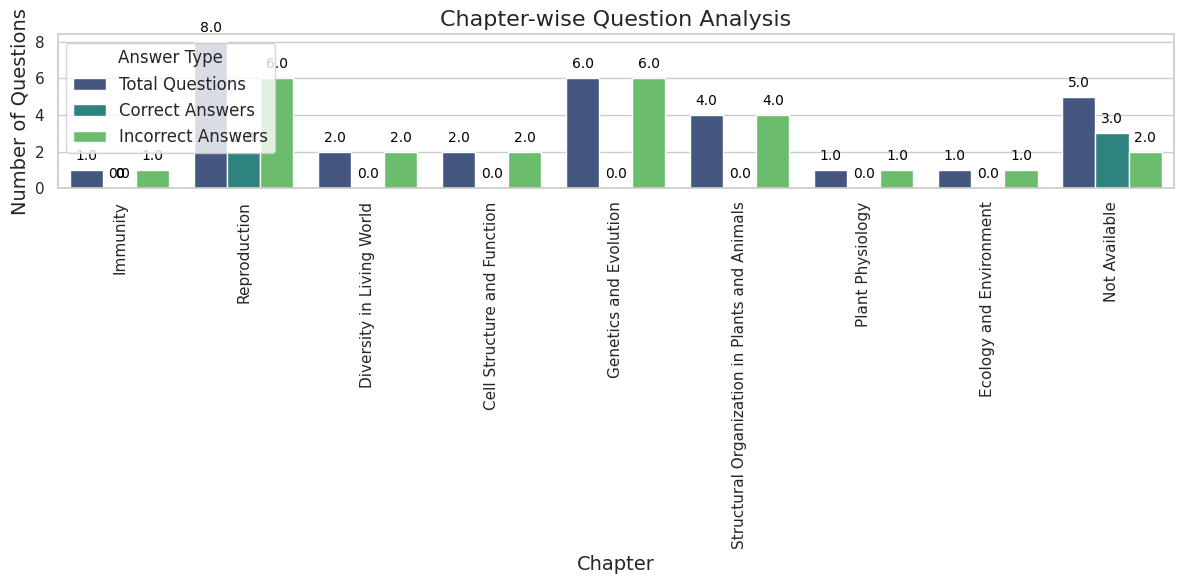

In [28]:
# Reshape the DataFrame for plotting
df_long = df.melt(id_vars='Chapter', value_vars=['Total Questions', 'Correct Answers', 'Incorrect Answers'],
                  var_name='Answer Type', value_name='Count')

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a bar plot with Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
bar_plot = sns.barplot(data=df_long, x='Chapter', y='Count', hue='Answer Type', palette='viridis')

# Add labels and title
plt.title('Chapter-wise Question Analysis', fontsize=16)
plt.xlabel('Chapter', fontsize=14)
plt.ylabel('Number of Questions', fontsize=14)
plt.xticks(rotation=90)  # Rotate x labels for better visibility
plt.legend(title='Answer Type', fontsize=12)

# Adding data labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

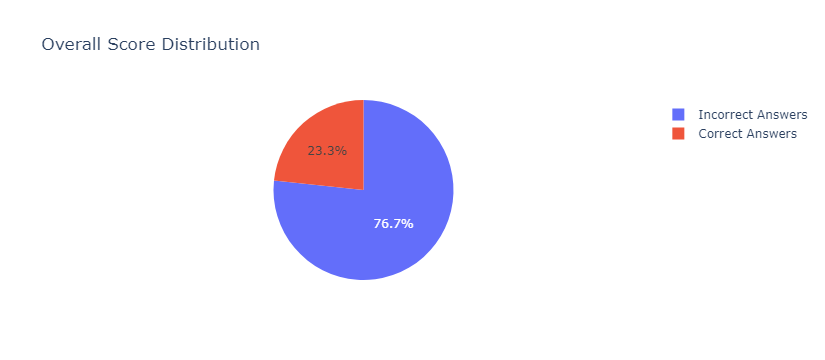

In [193]:
import re
import pandas as pd
import plotly.express as px

# Function to extract overall score summary data
def extract_overall_score_summary(text):
    # Regex pattern to match each line in the Overall Score Summary
    summary_pattern = re.search(
        r"\* Total Questions Answered:\s*(\d+)\s*"
        r"\* Total Correct Answers:\s*(\d+)\s*"
        r"\* Total Incorrect Answers:\s*(\d+)\s*"
        r"\* Overall Accuracy Percentage:\s*([\d.]+)%", text
    )

    # Check if match is found and extract data
    if summary_pattern:
        total_questions = int(summary_pattern.group(1))
        correct_answers = int(summary_pattern.group(2))
        incorrect_answers = int(summary_pattern.group(3))
        accuracy_percentage = float(summary_pattern.group(4))
        
        # Return the data as a dictionary
        return {
            "Total Questions Answered": total_questions,
            "Total Correct Answers": correct_answers,
            "Total Incorrect Answers": incorrect_answers,
            "Overall Accuracy Percentage": accuracy_percentage
        }
    
    return None

# Extract overall score summary
overall_score_data = extract_overall_score_summary(report)

pie_data = pd.DataFrame({
    "Answer Type": ["Correct Answers", "Incorrect Answers"],
    "Count": [overall_score_data["Total Correct Answers"], overall_score_data["Total Incorrect Answers"]]})

pie_data

fig = px.pie(pie_data, values='Count', names='Answer Type', title='Overall Score Distribution',
             color_discrete_sequence=px.colors.qualitative.Plotly)

# Display the pie chart
fig.show()

In [194]:
import re
import pandas as pd

def extract_topic_data(text):
    # Regex pattern to capture topic details
    topic_pattern = re.compile(
        r"\*\*\s*([^*]+)\s*\*\*:\s*(.*?)\s*(?=\*\*|\Z)", re.DOTALL
    )
    
    topics = []

    for match in topic_pattern.finditer(text):
        chapter_name = match.group(1).strip()
        subtopics_data = match.group(2).strip()
        
        # Extract subtopics using another regex
        subtopic_pattern = re.compile(
            r"\*\s*Subtopic:\s*([^:]+):?\s*"
            r"- Questions Attempted:\s*(\d+)\s*"
            r"- Correct Answers:\s*(\d+)\s*"
            r"- Incorrect Answers:\s*(\d+)\s*"
            r"- Accuracy Percentage:\s*([\d.]+)%"
        )
        
        for submatch in subtopic_pattern.finditer(subtopics_data):
            subtopic_name = submatch.group(1).strip()
            questions_attempted = int(submatch.group(2))
            correct_answers = int(submatch.group(3))
            incorrect_answers = int(submatch.group(4))
            accuracy_percentage = float(submatch.group(5))
            
            topics.append({
                "Chapter": chapter_name,
                "Subtopic": subtopic_name,
                "Questions Attempted": questions_attempted,
                "Correct Answers": correct_answers,
                "Incorrect Answers": incorrect_answers,
                "Accuracy Percentage": accuracy_percentage
            })

    return pd.DataFrame(topics)



# Extract topic data
topic_df = extract_topic_data(report)




In [195]:
topic_df

,Chapter,Subtopic,Questions Attempted,Correct Answers,Incorrect Answers,Accuracy Percentage
0,Reproduction,Embryonic development,3,0,3,0.00
1,Reproduction,Reproductive systems,3,1,2,33.33
2,Reproduction,Meiosis and crossing over,2,1,1,50.00
3,Diversity in Living World,Classification of living organisms,3,2,1,66.67
4,Diversity in Living World,Taxonomic categories,2,0,2,0.00
5,Cell Structure and Function,Cell membrane,1,1,0,100.00
6,Genetics and Evolution,Mendelian inheritance,1,0,1,0.00
7,Genetics and Evolution,Evolutionary theories,1,0,1,0.00


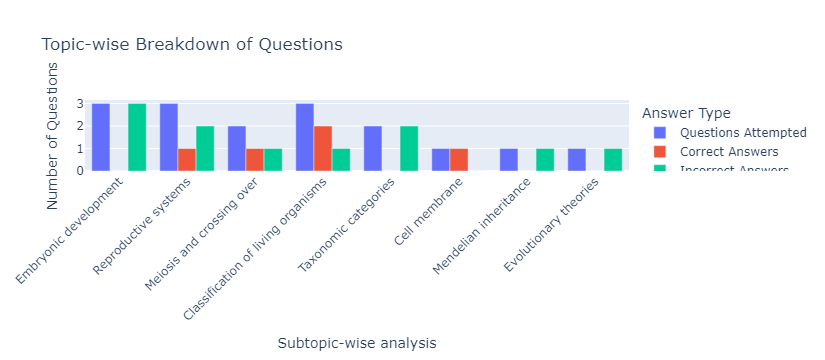

In [196]:
# Reshape the DataFrame for plotting
df_long = topic_df.melt(id_vars=["Chapter", "Subtopic"], 
                  value_vars=["Questions Attempted", "Correct Answers", "Incorrect Answers"],
                  var_name="Answer Type", value_name="Count")

# Create a grouped bar plot
fig = px.bar(df_long, x="Subtopic", y="Count", color="Answer Type", 
             barmode="group", 
             title="Topic-wise Breakdown of Questions",
             labels={"Count": "Number of Questions"},
             height=600)

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Subtopic-wise analysis",
    yaxis_title="Number of Questions",
    xaxis_tickangle=-45
)

# Display the plot
fig.show()